Merger notebook for combining the initially provided labels from different sources into
one file that can be iterated over by the MATLAB copying script.
Also contains some preliminary analysis of the labels.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

Root level (Diag1): 

1. Spinal muscular atrophies and other disorders
of the motor neurons
2. Disorders of motor nerve roots
3. Disorders of peripheral nerve
4. Disorders of neuromuscular transmission
5. Disorders of muscle

In [ ]:
def merge_diag(row, include_three=True):
  if np.isnan(row['Diag1']) | np.isnan(row['Diag2']):
    return np.nan
  
  diag_1 = str(int(row['Diag1'])) 
  diag_2 = str(int(row['Diag2']))

  if include_three:
    if np.isnan(row['Diag3']):
      return np.nan
      
    diag_3 = str(int(row['Diag3']))
    return diag_1 + '.' + diag_2 + '.' + diag_3
  return diag_1 + '.' + diag_2

In [ ]:
def set_relations(a,b):
  print(f'There are {len(a)} items in set a.')
  print(f'There are {len(b)} items in set b.')
  print(f'There are {len(a.intersection(b))} items that overlap.')
  print(f'There are {len(a.difference(b))} items only in a.')
  print(f'There are {len(b.difference(a))} items only in b.')

In [ ]:
cramp_patients = pd.read_excel('CRAMP_patients.xlsx')
cramp_patients.rename(inplace=True,columns={'Registratienummer' : 'pid'})

print(cramp_patients.shape)
cramp_patients.dropna(subset=['Diag1'],inplace=True)
print(cramp_patients.shape)

zero_patients = cramp_patients[cramp_patients['Diag1'] == 0]
zero_ids = set(zero_patients.pid)


# merge the diags 

cramp_patients['fullDiag'] = cramp_patients.apply(merge_diag,axis=1)
func = partial(merge_diag, include_three=False)
cramp_patients['halfDiag'] = cramp_patients.apply(func,axis=1)


duplicate_entries = cramp_patients[cramp_patients.duplicated(subset=['pid'], keep=False)]
duplicate_ids = set(duplicate_entries.pid)

set_relations(duplicate_ids,zero_ids)

(7280, 4)
(7245, 4)
There are 216 items in set a.
There are 51 items in set b.
There are 35 items that overlap.
There are 181 items only in a.
There are 16 items only in b.


There appear to be rather many duplicates, sometimes, patients have two diagnoses with correct codes, sometimes one of the entries is just totally empty. We'll just get rid of these entries entirely for now. We also need some way to prioritize the more specific diagnosis in case patients have multiple. If both are similarly specific, we just need to drop one. Depending on what we decide to do with the data downstream, it might be worth looking into this aspect further.

In [ ]:
def is_specific(row):
  # specific on all levels
  if (row['Diag1'] != 0) & (row['Diag2'] != 0) & (row['Diag2'] != 99):
    return 2
  # specific at least at the top level
  if (row['Diag1'] != 0):
    return 1
  # not specific at all
  return 0

cramp_patients['is_specific'] = cramp_patients.apply(is_specific,axis=1)
print(sum(cramp_patients['is_specific']))

# print(cramp_patients[cramp_patients['pid'] == '8622895'])
cramp_patients.sort_values(by=['pid', 'is_specific'], inplace=True, ascending = [True, True])

# print(cramp_patients[cramp_patients['pid'] == '8622895'])
# now if we keep the last duplicate, we should have the one with the specific diagnosis
tester = cramp_patients.drop_duplicates(subset=['pid'], keep='last')

duplicate_entries = cramp_patients[cramp_patients.duplicated(subset=['pid'], keep='first')]

print(tester['halfDiag'].value_counts())
still_zero = set(tester[tester['halfDiag'] =='0.0'].index)
set_relations(duplicate_ids, still_zero)
cramp_patients = tester

14062
5.1     1913
2.2     1526
3.1      498
1.7      457
5.4      444
5.3      413
3.3      406
5.99     275
4.3      206
3.5      184
1.1      125
3.13     120
3.11      77
3.8       65
1.5       59
3.9       53
3.6       50
5.2       18
3.10      17
0.0       16
3.7       11
5.8       11
4.1       11
3.4       10
1.2        8
5.0        7
5.5        6
1.9        5
3.0        4
3.12       4
1.6        3
3.2        2
2.0        2
1.0        2
1.8        2
1.3        1
5.9        1
4.0        1
22.2       1
1.4        1
Name: halfDiag, dtype: int64
There are 216 items in set a.
There are 16 items in set b.
There are 0 items that overlap.
There are 216 items only in a.
There are 16 items only in b.


In [ ]:
cramp_patients.set_index(inplace=True, keys='pid')


print(len(cramp_patients['fullDiag'].value_counts()))
print(len(cramp_patients['halfDiag'].value_counts()))


print(cramp_patients['Diag1'].value_counts())

print(cramp_patients[cramp_patients['Diag1'] == 5]['Diag2'].value_counts())

print(cramp_patients[(cramp_patients['Diag1'] == 5) & (cramp_patients['Diag2'] == 99)]['Diag3'].value_counts())

115
40
5.0     3089
2.0     1528
3.0     1501
1.0      663
4.0      218
0.0       16
22.0       1
Name: Diag1, dtype: int64
1.0     1913
4.0      444
3.0      413
99.0     275
2.0       18
8.0       11
0.0        7
5.0        6
9.0        1
Name: Diag2, dtype: int64
6.0    83
7.0    67
2.0    59
1.0    35
0.0    17
4.0     6
5.0     4
3.0     3
Name: Diag3, dtype: int64


In [ ]:
# export strange_cases
strange_cases = cramp_patients[(cramp_patients['Diag1'] == 0) | (cramp_patients['Diag1'] == 22)]
strange_cases.to_excel('strange_cases.xlsx')

5.0 --> Within this category, no further classification: 9 cases

5.1 --> **Heritable myopathies**: 1953 cases

*   5.1.1 Muscular dystrophies: 830
*   5.1.2 Congenital myopathies of unknown origin: 305
*   5.1.3 Myotonic disorders: 818

5.2 --> Trauma to muscle: 20 cases

5.3 --> **Inflammatory**: 424 cases

*   5.3.2: Other inflammatory diseases: 421 cases
*   5.3.3: Unknown etiology: 3 cases

5.4 --> **Metabolic myopathies**: 459 cases

*   5.4.0: ?
*   5.4.1: Associated with endocrine disease: 8 cases
*   5.4.2: Heritable myopathies, biochemical abnormality known: 431 cases
*   5.4.3: Other metabolic myopathies: 18 cases

5.5 --> Myopathy associated with malignant disease: 6 cases

5.6 --> 0 cases

5.7 --> 0 cases

5.8 --> Other disorders of unknown origin: 11 cases

5.9 --> Tumours of muscle: 1 case

5.99 --> **"Within the category"**: 302 cases

--> these also have a diag3, this ranges from 0 to 7, it indicates the symptoms the patients has reported

In [ ]:
for i in range(0,6):
  print(i)
  print(cramp_patients[cramp_patients['Diag1'] == i]['Diag2'].value_counts())


0
0.0    16
Name: Diag2, dtype: int64
1
7.0    457
1.0    125
5.0     59
2.0      8
9.0      5
6.0      3
8.0      2
0.0      2
4.0      1
3.0      1
Name: Diag2, dtype: int64
2
2.0    1526
0.0       2
Name: Diag2, dtype: int64
3
1.0     498
3.0     406
5.0     184
13.0    120
11.0     77
8.0      65
9.0      53
6.0      50
10.0     17
7.0      11
4.0      10
0.0       4
12.0      4
2.0       2
Name: Diag2, dtype: int64
4
3.0    206
1.0     11
0.0      1
Name: Diag2, dtype: int64
5
1.0     1913
4.0      444
3.0      413
99.0     275
2.0       18
8.0       11
0.0        7
5.0        6
9.0        1
Name: Diag2, dtype: int64


In [ ]:
def pad_pid(pid):
  to_pad = 7 - len(pid)
  new_pid = ''.join([*([to_pad * '0']),pid])
  return new_pid

all_patients = pd.read_csv('patients.csv') # pd.concat([initial_patients, archive_patients])
all_patients.pid = all_patients.pid.astype(str)
all_patients.pid = all_patients.pid.apply(pad_pid)
#print(all_patients.pid)

all_patients = all_patients.groupby('pid').max()

#print(all_patients.index)
all_patients['Sex'] = all_patients['Sex'].apply(lambda x : x.upper())
all_patients['Sex'] = all_patients['Sex'].replace({'V': 'F', 'W': 'F'})
all_patients['RecordingDate'] = pd.to_datetime(all_patients['RecordingDate'])
all_patients['Side'] = all_patients['Side'].replace({'-': np.NaN})
all_patients['BMI'] = all_patients.Weight / np.square(all_patients.Height /100)
# there are multiple records for each patient, merge these based on the id

Class                 fullDiag
NMD                   1.1.1        1
                      1.7.1        4
                      2.2.6        7
                      3.1.1        1
                      3.1.4        1
                      4.3.3        1
                      5.1.1       20
                      5.1.2        6
                      5.1.3        3
                      5.3.2       13
                      5.4.2        1
                      5.99.2       1
no NMD                5.1.2        2
                      5.4.2        2
unknown or uncertain  5.1.1        1
                      5.4.2        2
                      5.99.6       1
dtype: int64
(67, 14)
         Height  Weight Sex       Age  ... Diag3 fullDiag halfDiag  is_specific
pid                                    ...                                     
0041033   186.0    96.0   M  45.19640  ...   3.0    5.1.3      5.1          2.0
0052301   189.0   110.0   M  49.85080  ...   1.0    5.1.1      5.1          2.

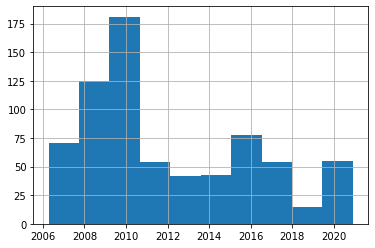

In [ ]:
all_patients_merged = all_patients.join(other=cramp_patients)

both_types = all_patients_merged[~(all_patients_merged['Class'].isna()) & ~(all_patients_merged['fullDiag'].isna())]
print(both_types.groupby(['Class', 'fullDiag']).size())
print(both_types.shape)

disagreement = both_types[(both_types['Class'] == 'no NMD') | (both_types['Class'] == 'unknown or uncertain')]
disagreement.to_excel('disagreement.xlsx')

cramp_label_available = all_patients_merged[(all_patients_merged['Class'].isna()) & ~(all_patients_merged['Diag1'].isna())]

print(cramp_label_available)

print(cramp_label_available['Diag1'].value_counts())

cramp_label_available['RecordingDate'].hist()


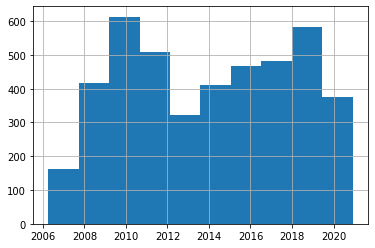

In [ ]:
all_patients['RecordingDate'].hist()

In [ ]:
# export the totality of labeled patients (from both sources)

all_labeled = all_patients_merged[(~all_patients_merged['Class'].isna()) | ~(all_patients_merged['Diag1'].isna())]

def consolidate_class(row):
  if not pd.isnull(row['Class']):
    return row['Class']
  if not pd.isnull(row['halfDiag']):
    return 'cramp_' + str(row['halfDiag'])
  return np.nan

all_labeled['exportClass'] = all_labeled.apply(consolidate_class,axis=1)
all_labeled[(all_labeled['Class'].isna())]['halfDiag'].value_counts()

all_labeled.drop(all_labeled.columns.difference(['pid','exportClass']), 1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
controls = pd.read_csv('controls.csv')
controls['Class'].value_counts()
controls.rename(inplace=True,columns={'Class' : 'exportClass'})
controls.set_index(inplace=True, keys='pid')

all_labeled = pd.concat([all_labeled, controls])
print(all_labeled.head())

all_labeled.rename(inplace=True,columns={'exportClass' : 'class'})

all_labeled.to_excel('labeledPatients_cramp_controls.xlsx')

        exportClass
pid                
0007036      no NMD
0019520      no NMD
0041033   cramp_5.1
0052301   cramp_5.1
0095808   cramp_1.7


In [ ]:
all_labeled.head()

,class
pid,
0007036,no NMD
0019520,no NMD
0041033,cramp_5.1
0052301,cramp_5.1
0095808,cramp_1.7


In [ ]:
#!pip install pandas-profiling==2.6.0

from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(all_patients, title='All patients')

In [ ]:
profile.to_file(output_file="patient_report.html")